In [1]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd 
from pandas import DataFrame, Series
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import potions as pt

# Load data

In [2]:
data_path: str = "../input/Sleepers_Results.txt"
in_df: DataFrame = pd.read_csv(data_path, sep="\\s+", index_col="Date", parse_dates=True)

In [3]:
in_df.head(1)

,Qsim,Qobs,Precipitation,Temperature,AET,PET,Snow,Snowcover,SM,Recharge,SUZ,SLZ,Q0,Q1,Q2,Qsim_rain,Qsim_snow
Date,,,,,,,,,,,,,,,,,
2016-10-01,0.49827,0.138,0.0,8.7,1.29,2.27,0.0,0.0,92.7,0.0,0.0,6.3,0.0,0.0,0.49827,0.496,0.002


# Create model and data structures

In [4]:
dates: Series = in_df.index # type: ignore
forc: pt.ForcingData = pt.ForcingData(
    precip=in_df.Precipitation,
    temp=in_df.Temperature,
    pet=in_df.PET
)

In [11]:
snow_zone: pt.SnowZone = pt.SnowZone(0.0, 1.0)
soil_zone: pt.SoilZone = pt.SoilZone(0.0, 100, 0.5, 1.0, 0.1, 50.0)
ground_zone: pt.GroundZone = pt.GroundZone(1e-3, 1.0, 1.0)

hs: pt.Hillslope = pt.Hillslope([
    pt.Layer([snow_zone]),
    pt.Layer([soil_zone]),
    pt.Layer([ground_zone])
]) # type: ignore

model = pt.Model(
    [hs],
    scales = [[1.0]],
    verbose=True
)

Flattened scales: [1.0]
Connection matrix: [[1.]
 [1.]
 [1.]]
Sizes array: [1.]
Connection matrix: [[1.]
 [1.]
 [1.]]
Sizes array: [1.]


In [6]:
model.get_size_mat().shape

(3, 1)

In [7]:
type(forc)

potions.model.ForcingData

In [8]:
init_state: NDArray = np.array([0.0, 25.0, 50.0])
res = pt.run_hydro_model(
    model,
    init_state=init_state,
    forc=[forc],
    dates=dates,
    dt=1.0
)

In [9]:
len(model)

3

# Plot Results

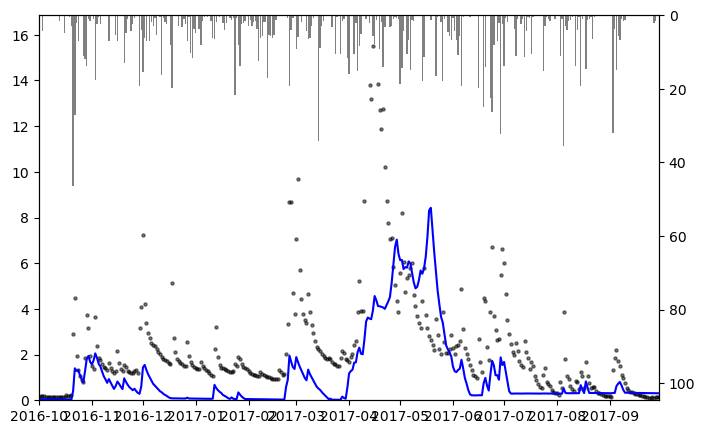

In [10]:
q_riv: Series = res["q_lat_snow_0"] + res["q_lat_soil_1"] + res["q_lat_ground_2"]
fig: Figure = plt.figure(figsize=(8,5))
ax: Axes = fig.gca()

ax.plot(dates, q_riv, label="Stream", color="Blue")
ax.scatter(dates, in_df["Qobs"], label="obs", color="black", s=5, alpha=0.5)
ax.set_ylim(0, 2 * q_riv.max())
ax.set_xlim(dates.min(), dates.max())

ax2: Axes = ax.twinx()

ax2.bar(dates, in_df.Precipitation, color="gray")
ax2.set_ylim(0, 2.25 * in_df["Precipitation"].max())
ax2.invert_yaxis()